In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


filename = '../dataset/pv/cough/clean_throat_0202.txt'
data = pd.read_csv(filename,
                   skiprows=7,
                   header=None,
                   delimiter='\t')

timestamps = data[0].to_numpy()-data[0][0]
central = data[1].to_numpy()
bottom = data[2].to_numpy()
left = data[3].to_numpy()
right = data[4].to_numpy()

plt.plot(timestamps, bottom)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/pv/cough/clean_throat_0202.txt'

Clean throat

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

def sea_det(sig, period_h, period_l):
    sig_h = seasonal_decompose(sig,
                               model='additive',
                               period=period_h,
                               extrapolate_trend='freq')
    sig_l = seasonal_decompose(sig,
                               model='additive',
                               period=period_l,
                               extrapolate_trend='freq')
    return sig_h.trend-sig_l.trend

(0.0, 9.0)

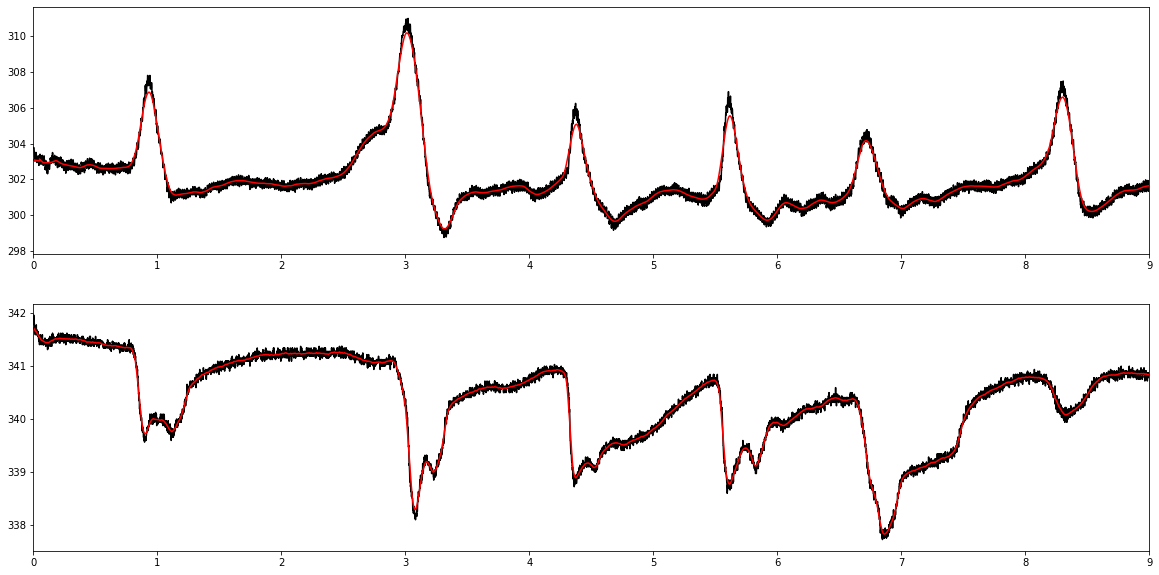

In [4]:
central_d = seasonal_decompose(central, model='additive', period=100, extrapolate_trend='freq')
bottom_d = seasonal_decompose(bottom, model='additive', period=50, extrapolate_trend='freq')

fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(211)
ax.plot(timestamps, central, 'k-')
ax.plot(timestamps, central_d.trend, 'r-')
ax.set_xlim([0, 9])

ax = fig.add_subplot(212)
ax.plot(timestamps, bottom, 'k-')
ax.plot(timestamps, bottom_d.trend, 'r-')
ax.set_xlim([0, 9])

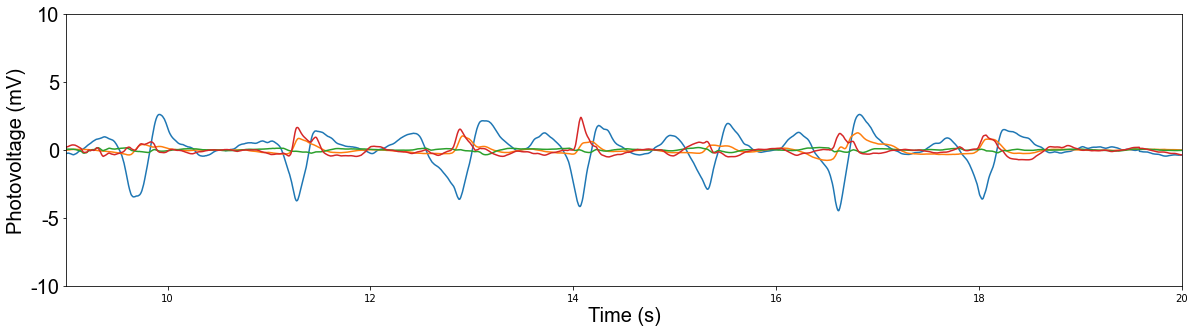

In [5]:
font = {'family': 'arial',
        'size': 20}

central_det = sea_det(central, 1000, 50)
bottom_det = sea_det(bottom, 1000, 50)
left_det = sea_det(left, 1000, 50)
right_det = sea_det(right, 1000, 50)

fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot()

ax.plot(timestamps, central_det)
ax.plot(timestamps, bottom_det)
ax.plot(timestamps, left_det)
ax.plot(timestamps, right_det)

ax.set_xlim([9, 20])
# ax.set_xticks(np.arange(0, 25, 5))
# ax.set_xticklabels(np.arange(0, 25, 5), fontdict=font)
ax.set_xlabel('Time (s)', fontdict=font)

ax.set_ylim([-10, 10])
ax.set_yticks(np.arange(-10, 15, 5))
ax.set_yticklabels(np.arange(-10, 15, 5), fontdict=font)
ax.set_ylabel('Photovoltage (mV)', fontdict=font)

plt.show()

Training

In [6]:
fs = 1000

# Manual labeling the positive sections for train set

timestamps_train = np.arange(0*fs, 9*fs).astype(int)
section1 = np.arange(0.5*fs, 1.5*fs).astype(int)
section2 = np.arange(2.5*fs, 3.6*fs).astype(int)
section3 = np.arange(3.8*fs, 5*fs).astype(int)
section4 = np.arange(5.2*fs, 6*fs).astype(int)
section5 = np.arange(6.3*fs, 7.3*fs).astype(int)
section6 = np.arange(8*fs, 8.6*fs).astype(int)

central_train = central_det[np.arange(0*fs, 9*fs)]
bottom_train = bottom_det[np.arange(0*fs, 9*fs)]
left_train = left_det[np.arange(0*fs, 9*fs)]
right_train = right_det[np.arange(0*fs, 9*fs)]
positive_sections_train = np.concatenate((section1, section2, section3, section4, section5, section6))
tags_train = np.array([1 if t in positive_sections_train else 0 for t in timestamps_train])

# Manual labeling the positive sections for test set

timestamps_test = np.arange(9*fs, 20*fs).astype(int)
section7 = np.arange(9*fs, 10.2*fs).astype(int)
section8 = np.arange(10.7*fs, 11.8*fs).astype(int)
section9 = np.arange(12.1*fs, 13.4*fs).astype(int)
section10 = np.arange(13.5*fs, 14.5*fs).astype(int)
section11 = np.arange(14.7*fs, 15.7*fs).astype(int)
section12 = np.arange(16*fs, 17.2*fs).astype(int)
section13 = np.arange(17.4*fs, 18.6*fs).astype(int)

central_test = central_det[np.arange(9*fs, 20*fs)]
bottom_test = bottom_det[np.arange(9*fs, 20*fs)]
left_test = left_det[np.arange(9*fs, 20*fs)]
right_test = right_det[np.arange(9*fs, 20*fs)]
positive_sections_test = np.concatenate((section7, section8, section9, section10, section11, section12, section13))
tags_test = np.array([1 if t in positive_sections_test else 0 for t in timestamps_test])

tag_to_ix = {"P": 1,
             "N": 0}

In [7]:
import sys
import torch
sys.path.insert(0, '../')

from denoise import pv_det_sea

clean_throat_path = '../dataset/pv/cough/clean_throat_0202.txt'
cough_path = '../dataset/pv/cough/cough_0202.txt'

max_time = 20
max_amp = 65

y_interval = np.around(max_amp, -1)/3

def load(path):
    data = pd.read_csv(path,
                       skiprows=6,
                       delimiter='\t').to_numpy()
    fs = 1000.
    pv = data[:, 1:]
    print(np.shape(pv))
    pv_det = pv_det_sea(pv=pv,
                        fs=fs,
                        denoise_len_s=0.2)
    return pv_det


In [8]:
clean_throat_np=load(clean_throat_path)
clean_throat_train=torch.from_numpy(clean_throat_np[0:9000,].astype('float32'))
clean_throat_train_label=torch.cat((torch.zeros(500),
                             torch.ones(1000),
                             torch.zeros(1000),
                             torch.ones(1100),
                             torch.zeros(200),
                             torch.ones(1200),
                             torch.zeros(200),
                             torch.ones(800),
                             torch.zeros(300),
                             torch.ones(1000),
                             torch.zeros(700),
                             torch.ones(600),
                             torch.zeros(400)),
                             0).type(torch.LongTensor)

clean_throat_test=torch.from_numpy(clean_throat_np[9000:,].astype('float32'))
clean_throat_test_label=torch.cat((torch.ones(1200),
                             torch.zeros(500),
                             torch.ones(1100),
                             torch.zeros(300),
                             torch.ones(1300),
                             torch.zeros(100),
                             torch.ones(1000),
                             torch.zeros(200),
                             torch.ones(1000),
                             torch.zeros(300),
                             torch.ones(1200),
                             torch.zeros(200),
                             torch.ones(1200),
                             torch.zeros(1479)),
                             0
                             ).type(torch.LongTensor)

(20079, 4)


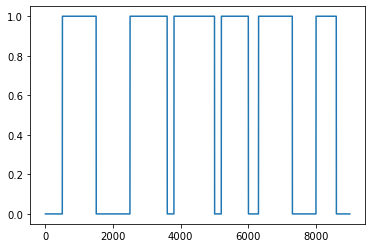

In [9]:
plt.plot(clean_throat_train_label)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(10086)

In [11]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, hidden_dim, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)

        # self.desperateLayer = nn.Linear(hidden_dim, hidden_dim)
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, data):
        lstm_out, _ = self.lstm(data.view(len(data), 1, -1))
        # lstm_out_update = self.desperateLayer(lstm_out)
        tag_space = self.hidden2tag(lstm_out.view(len(data), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
INPUT_DIM = 4
HIDDEN_DIM = 6
TARGET_SIZE = 2

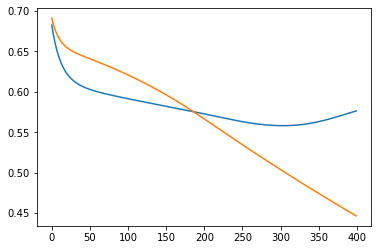

In [12]:
torch.manual_seed(10086)
train_losses = []
test_losses = []

model = LSTMTagger(INPUT_DIM, HIDDEN_DIM, TARGET_SIZE)
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)
#         print(param.data)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(400):  
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
    model.zero_grad()

        # Step 2. Run our forward pass.
    tag_scores = model(clean_throat_train)

        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
    loss = loss_function(tag_scores, clean_throat_train_label)
    loss.backward()

    optimizer.step()

    #record the test error value for each epoch    
    with torch.no_grad():
        tag_scores = model(clean_throat_test)
        test_loss = loss_function(tag_scores, clean_throat_test_label)
        test_losses.append(test_loss.item())

        train_scores=model(clean_throat_train)
        train_loss = loss_function(train_scores, clean_throat_train_label)
        train_losses.append(train_loss.item())

plt.plot(test_losses, '-')
plt.plot(train_losses, '-')

In [27]:
np.arange(0, tag.shape[0]/1000, 0.001)

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 1.1076e+01, 1.1077e+01,
       1.1078e+01])

In [34]:
clean_throat_test_label.shape

torch.Size([11079])

In [41]:
clean_throat_test.shape

torch.Size([11079, 4])

(-5.0, 5.0)

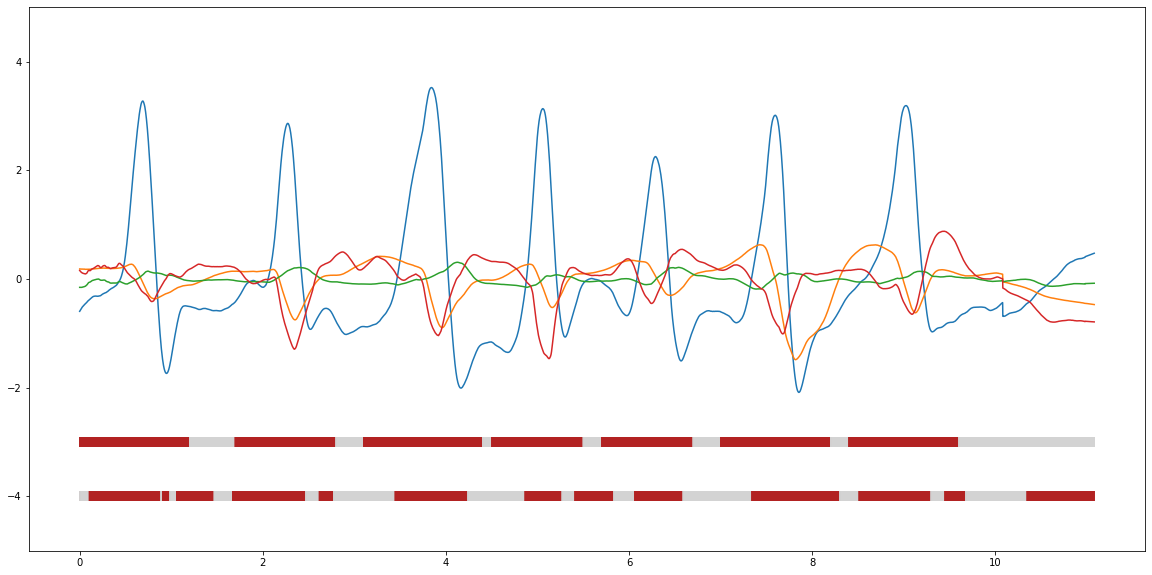

In [51]:
with torch.no_grad():
    tag_scores = model(clean_throat_test)
    tag = torch.argmax(tag_scores,dim=1)
    
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot()
color_predict = np.where(tag == 1, 'firebrick', 'lightgrey')
color_groundtruth = np.where(clean_throat_test_label, 'firebrick', 'lightgrey')

timestamps_test_s = np.arange(0, tag.shape[0]/1000, 0.001)

ax.plot(timestamps_test_s, clean_throat_test)
ax.scatter(timestamps_test_s, -4*np.ones(timestamps_test_s.size),
           s=100, c=color_predict, alpha=0.5, marker='|')
ax.scatter(timestamps_test_s, -3*np.ones(timestamps_test_s.size),
           s=100, c=color_groundtruth, alpha=0.5, marker='|')

ax.set_ylim([-5, 5])